In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#setting device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
#Transformations for training and testing datasets

transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [34]:
# Downloading and preparing data

train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(train_data, batch_size=8, shuffle=True)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(test_data, batch_size=8, shuffle=False)

In [56]:
trainloader, testloader
print(f"trainloader: {len(train_data)}")
print(f"testloader: {len(test_data)}")

trainloader: 50000
testloader: 10000


In [57]:
num_classes = train_data.classes
classes_to_idx = train_data.class_to_idx

In [58]:
# checking dataset
print(f"printing some details of the dataset")
print(f"Shape of one image {train_data[0][0].shape}")
print(f"label of one image {train_data[0][1]}")
print(f"Total number of images {len(train_data)} \nTotal classes {num_classes} \nMapping of classes to indices {classes_to_idx}")
print(f"Total classes {len(train_data.classes)}")

printing some details of the dataset
Shape of one image torch.Size([3, 224, 224])
label of one image 6
Total number of images 50000 
Total classes ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 
Mapping of classes to indices {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Total classes 10


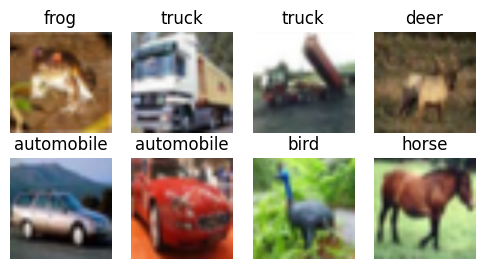

In [59]:
# Visualizing some images from data
plt.figure(figsize=(6,3))
for i in range(8):
    plt.subplot(2,4,i+1)
    image = train_data[i][0].permute(1, 2, 0)
    image = image.numpy()
    image_data_uint8 = (image * 255).astype('uint8')

    label = train_data[i][1]
    plt.imshow(image)
    plt.title(num_classes[label])
    plt.axis('off')
plt.show()

In [60]:
#loading Pre-Trained ResNet-152 and replacing Classification Head

model = torchvision.models.resnet152(weights="IMAGENET1K_V2")
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

In [61]:
#freezing all layers except classification Head

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

#Loss and Optimizer Functions

CELoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [9]:
#Training

def train_model(model, trainloader, optimizer, CELoss):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        y_pred = model(images)
        loss = CELoss(y_pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)  #current loss * no of images in batch to accumulate total loss across all samples in epoch
        _, predicted = y_pred.max(1)
        correct += predicted.eq(labels).sum().item()
        total += y_pred.size(0)

    return running_loss / total, 100. * correct / total

In [10]:
#Testing/Evaluation

def test_model(model, testloader, CELoss):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.inference_mode():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = CELoss(y_pred, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = y_pred.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, 100 * correct / total

In [64]:
#Running Training for 10 Epochs

import tqdm
from timeit import default_timer as timer
start_time = timer()
epochs = 10
for epoch in tqdm.tqdm(range(epochs)):
    start_time = timer()
    train_loss, train_acc = train_model(model, trainloader, optimizer, CELoss)
    val_loss, val_acc = test_model(model, testloader, CELoss)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},"
    f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    end_time = timer()
    print(f"Epoch time: {end_time - start_time:.2f} seconds")



 10%|█         | 1/10 [10:00<1:30:05, 600.64s/it]

Epoch: 1, Train Loss: 0.7327, Train Acc: 76.0060,Val Loss: 0.5853, Val Acc: 82.1400
Epoch time: 600.64 seconds


 20%|██        | 2/10 [20:03<1:20:17, 602.13s/it]

Epoch: 2, Train Loss: 0.6185, Train Acc: 79.2920,Val Loss: 0.5207, Val Acc: 82.9900
Epoch time: 603.17 seconds


 30%|███       | 3/10 [30:06<1:10:18, 602.59s/it]

Epoch: 3, Train Loss: 0.5990, Train Acc: 79.9920,Val Loss: 0.5827, Val Acc: 82.6700
Epoch time: 603.14 seconds


 40%|████      | 4/10 [40:10<1:00:17, 602.91s/it]

Epoch: 4, Train Loss: 0.5855, Train Acc: 80.2260,Val Loss: 0.5199, Val Acc: 82.8500
Epoch time: 603.40 seconds


 50%|█████     | 5/10 [50:12<50:13, 602.70s/it]  

Epoch: 5, Train Loss: 0.5792, Train Acc: 80.6000,Val Loss: 0.5095, Val Acc: 83.8400
Epoch time: 602.32 seconds


 60%|██████    | 6/10 [1:00:15<40:10, 602.71s/it]

Epoch: 6, Train Loss: 0.5746, Train Acc: 80.8220,Val Loss: 0.5005, Val Acc: 83.4000
Epoch time: 602.74 seconds


 70%|███████   | 7/10 [1:10:18<30:08, 602.91s/it]

Epoch: 7, Train Loss: 0.5746, Train Acc: 80.6760,Val Loss: 0.4972, Val Acc: 83.6800
Epoch time: 603.32 seconds


 80%|████████  | 8/10 [1:20:21<20:05, 602.78s/it]

Epoch: 8, Train Loss: 0.5725, Train Acc: 80.8760,Val Loss: 0.6280, Val Acc: 81.8600
Epoch time: 602.50 seconds


 90%|█████████ | 9/10 [1:30:23<10:02, 602.56s/it]

Epoch: 9, Train Loss: 0.5675, Train Acc: 81.1620,Val Loss: 0.5210, Val Acc: 83.1600
Epoch time: 602.06 seconds


100%|██████████| 10/10 [1:40:25<00:00, 602.58s/it]

Epoch: 10, Train Loss: 0.5695, Train Acc: 80.9760,Val Loss: 0.5654, Val Acc: 83.1400
Epoch time: 602.45 seconds


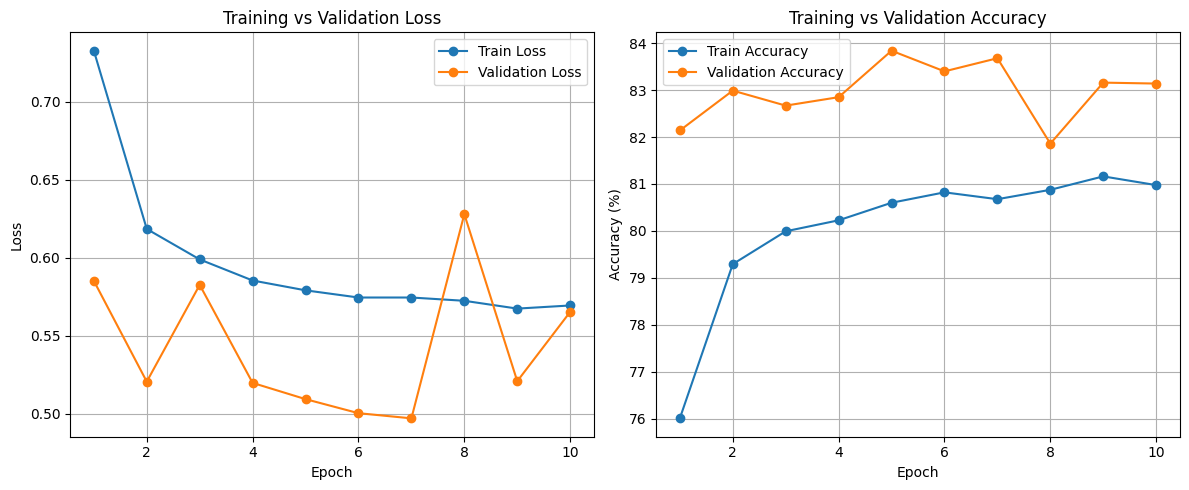

In [2]:
import matplotlib.pyplot as plt

# Extracted from your logs
train_loss = [0.7327, 0.6185, 0.5990, 0.5855, 0.5792, 0.5746, 0.5746, 0.5725, 0.5675, 0.5695]
val_loss   = [0.5853, 0.5207, 0.5827, 0.5199, 0.5095, 0.5005, 0.4972, 0.6280, 0.5210, 0.5654]

train_acc  = [76.0060, 79.2920, 79.9920, 80.2260, 80.6000, 80.8220, 80.6760, 80.8760, 81.1620, 80.9760]
val_acc    = [82.1400, 82.9900, 82.6700, 82.8500, 83.8400, 83.4000, 83.6800, 81.8600, 83.1600, 83.1400]

epochs = range(1, 11)

# Plot losses
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'o-', label="Train Loss")
plt.plot(epochs, val_loss, 'o-', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'o-', label="Train Accuracy")
plt.plot(epochs, val_acc, 'o-', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
# using Normalization on Training and Testind data to check how accuracy changes

transform_train_v2 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test_v2 = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [5]:
# Downloading and preparing data

train_data_v2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train_v2)
trainloader_v2 = DataLoader(train_data_v2, batch_size=8, shuffle=True)

test_data_v2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test_v2)
testloader_v2 = DataLoader(test_data_v2, batch_size=8, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [6]:
trainloader_v2, testloader_v2
print(f"trainloader: {len(train_data_v2)}")
print(f"testloader: {len(test_data_v2)}")

trainloader: 50000
testloader: 10000


In [7]:
#loading Pre-Trained ResNet-152 and replacing Classification Head

model_v2 = torchvision.models.resnet152(weights="IMAGENET1K_V2")
num_features = model_v2.fc.in_features
model_v2.fc = nn.Linear(num_features, 10)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:02<00:00, 117MB/s] 


In [8]:
#freezing all layers except classification Head

for param in model_v2.parameters():
    param.requires_grad = False
for param in model_v2.fc.parameters():
    param.requires_grad = True

model_v2 = model_v2.to(device)

#Loss and Optimizer Functions

CELoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v2.fc.parameters(), lr=1e-3)

In [11]:
#Running Training for 10 Epochs

import tqdm
from timeit import default_timer as timer
start_time = timer()
epochs = 10
for epoch in tqdm.tqdm(range(epochs)):
    start_time = timer()
    train_loss, train_acc = train_model(model_v2, trainloader_v2, optimizer, CELoss)
    val_loss, val_acc = test_model(model_v2, testloader_v2, CELoss)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},"
    f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    end_time = timer()
    print(f"Epoch time: {end_time - start_time:.2f} seconds")



 10%|█         | 1/10 [10:06<1:30:59, 606.63s/it]

Epoch: 1, Train Loss: 0.7344, Train Acc: 75.6260,Val Loss: 0.4965, Val Acc: 83.9700
Epoch time: 606.63 seconds


 20%|██        | 2/10 [20:12<1:20:49, 606.21s/it]

Epoch: 2, Train Loss: 0.6266, Train Acc: 78.9920,Val Loss: 0.5559, Val Acc: 81.8300
Epoch time: 605.90 seconds


 30%|███       | 3/10 [30:18<1:10:42, 606.01s/it]

Epoch: 3, Train Loss: 0.6078, Train Acc: 79.6420,Val Loss: 0.5076, Val Acc: 82.9400
Epoch time: 605.78 seconds


 40%|████      | 4/10 [40:24<1:00:36, 606.08s/it]

Epoch: 4, Train Loss: 0.5886, Train Acc: 80.3180,Val Loss: 0.4936, Val Acc: 83.7300
Epoch time: 606.19 seconds


 50%|█████     | 5/10 [50:30<50:30, 606.06s/it]  

Epoch: 5, Train Loss: 0.5883, Train Acc: 80.2860,Val Loss: 0.4884, Val Acc: 83.9300
Epoch time: 606.01 seconds


 60%|██████    | 6/10 [1:00:35<40:23, 605.77s/it]

Epoch: 6, Train Loss: 0.5865, Train Acc: 80.5360,Val Loss: 0.4982, Val Acc: 83.7600
Epoch time: 605.22 seconds


 70%|███████   | 7/10 [1:10:41<30:17, 605.69s/it]

Epoch: 7, Train Loss: 0.5809, Train Acc: 80.9080,Val Loss: 0.5343, Val Acc: 82.5600
Epoch time: 605.52 seconds


 80%|████████  | 8/10 [1:20:45<20:10, 605.30s/it]

Epoch: 8, Train Loss: 0.5821, Train Acc: 80.7240,Val Loss: 0.4882, Val Acc: 83.8500
Epoch time: 604.47 seconds


 90%|█████████ | 9/10 [1:30:52<10:05, 605.63s/it]

Epoch: 9, Train Loss: 0.5791, Train Acc: 80.6960,Val Loss: 0.5228, Val Acc: 82.8800
Epoch time: 606.34 seconds


100%|██████████| 10/10 [1:40:56<00:00, 605.64s/it]

Epoch: 10, Train Loss: 0.5721, Train Acc: 80.9440,Val Loss: 0.5058, Val Acc: 83.2900
Epoch time: 604.34 seconds


In [ ]:
torch.save(model_v2)